<a href="https://colab.research.google.com/github/cuauhtemocbe/Diplomado-Ciencia-Datos/blob/main/notebooks/Clasificaci%C3%B3n_Pok%C3%A9mons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# Data Wrangling
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Modeling
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Data Visualization
import cufflinks as cf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Configuración del notebook
cf.go_offline()
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.FATAL)

# Librerías adicionales
import shutil

def copy_images(data, folder_name, images_dir):
    for _, row in data.iterrows():
        name = row['Name']
        type1 = row['Type1']

        # Construir las rutas de los archivos de origen para ambos formatos
        png_source_file = os.path.join(images_dir, f"{name}.png")
        jpg_source_file = os.path.join(images_dir, f"{name}.jpg")

        # Construir la ruta del archivo de destino
        dest_dir = os.path.join(folder_name, type1)

        # Copiar el archivo PNG si existe
        if os.path.exists(png_source_file):
            dest_file = os.path.join(dest_dir, f"{name}.png")
            shutil.copy(png_source_file, dest_file)
        # Copiar el archivo JPG si existe
        elif os.path.exists(jpg_source_file):
            dest_file = os.path.join(dest_dir, f"{name}.jpg")
            shutil.copy(jpg_source_file, dest_file)
        else:
            print(f"El archivo {name} no existe en formato PNG o JPG.")


def display_sample_images(df, image_folder, num_images=16, rows=4, cols=4):
    """"""
    # Selecciona un muestreo aleatorio de imágenes
    sampled_images = df['Name'].sample(n=num_images).tolist()

    # Configura el tamaño de la figura
    fig = plt.gcf()
    fig.set_size_inches(24, 24)
    plt.figure(figsize=(12, 10), dpi=80)

    # Mostrar las imágenes
    for i, img_name in enumerate(sampled_images):
        # Probar ambas extensiones
        img_paths = [
            os.path.join(image_folder, f"{img_name}.jpg"),
            os.path.join(image_folder, f"{img_name}.png")
        ]

        img_path = None
        for path in img_paths:
            if os.path.exists(path):
                img_path = path
                break

        # Si se encuentra la imagen, se muestra
        if img_path:
            sp = plt.subplot(rows, cols, i + 1)
            sp.axis('Off')
            img = mpimg.imread(img_path)
            sp.set_title(os.path.basename(img_path), fontsize=6)
            plt.imshow(img)
        else:
            print(f"No se encontró la imagen para: {img_name}")

    plt.tight_layout()
    plt.show()


## Preparación de las carpetas

In [2]:
!wget https://github.com/cuauhtemocbe/Diplomado-Ciencia-Datos/blob/main/data/Pok%C3%A9mons.zip?raw=true -O pokemons.zip
!unzip pokemons.zip > /dev/null

--2024-10-05 19:11:33--  https://github.com/cuauhtemocbe/Diplomado-Ciencia-Datos/blob/main/data/Pok%C3%A9mons.zip?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/cuauhtemocbe/Diplomado-Ciencia-Datos/raw/refs/heads/main/data/Pok%C3%A9mons.zip [following]
--2024-10-05 19:11:33--  https://github.com/cuauhtemocbe/Diplomado-Ciencia-Datos/raw/refs/heads/main/data/Pok%C3%A9mons.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cuauhtemocbe/Diplomado-Ciencia-Datos/refs/heads/main/data/Pok%C3%A9mons.zip [following]
--2024-10-05 19:11:33--  https://raw.githubusercontent.com/cuauhtemocbe/Diplomado-Ciencia-Datos/refs/heads/main/data/Pok%C3%A9mons.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.13

### Estableciendo las rutas

In [3]:
main_dir = "Pokémons/dataset"
metadata_dir = train_dir = os.path.join(main_dir, 'pokemon.csv')

train_dir = os.path.join(main_dir, 'train')
validation_dir = os.path.join(main_dir, 'val')
test_dir = os.path.join(main_dir, 'test')

## Análisis de la metadata

In [4]:
df = pd.read_csv(metadata_dir)
df.head()

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN


In [5]:
count_df = df.value_counts('Type1').reset_index()
count_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
Type1,Water,Normal,Grass,Bug,Fire,Psychic,Rock,Electric,Poison,Ground,Fighting,Dark,Ghost,Dragon,Steel,Ice,Fairy,Flying
count,114,105,78,72,53,53,46,40,34,32,29,29,27,27,26,23,18,3


**Nota:** Hay pocos registros para Fairy y Flying

In [6]:
threshold = 20
types_with_few_samples = count_df[count_df["count"] < threshold]["Type1"].to_list()
types_with_few_samples

['Fairy', 'Flying']

In [7]:
# Agregando más datos para Fairy y Flying
n_samples = 20
sampled_df = pd.DataFrame()
for pokemon_type in types_with_few_samples:
  tmp_df = df[df['Type2'] == pokemon_type].sample(n_samples, random_state=42)
  tmp_df.loc[:, "Type1"] = tmp_df["Type2"]

  if sampled_df.empty:
        sampled_df = tmp_df
  else:
        sampled_df = pd.concat([sampled_df, tmp_df])

In [8]:
df = pd.concat([df, sampled_df]).reset_index(drop=True)
df[df["Type1"].isin(types_with_few_samples)].value_counts('Type1')

,count
Type1,
Fairy,38
Flying,23


## Train, Validation & Test

In [9]:
from re import X
from sklearn.model_selection import train_test_split

# Dividir el DataFrame en train y un conjunto temporal (test + validation)
train_df, temp_df = train_test_split(
    df, test_size=0.4, random_state=42, stratify=df['Type1']
)

# Dividir el conjunto temporal en test y validation
test_df, validation_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df['Type1']
)

**Tamaño de los conjuntos de datos**

In [13]:
print(f"Tamaño del conjunto de entrenamiento: {len(train_df)}")
print(f"Tamaño del conjunto de validación: {len(validation_df)}")
print(f"Tamaño del conjunto de prueba: {len(test_df)}")

Tamaño del conjunto de entrenamiento: 509
Tamaño del conjunto de validación: 170
Tamaño del conjunto de prueba: 170


## Organizando imágenes en train, validation y test

In [10]:
for folder in [train_dir, test_dir, validation_dir]:
    os.makedirs(folder, exist_ok=True)

    # Crear subcarpetas para cada Type1
    for type1 in pd.concat([train_df, test_df, validation_df])['Type1'].unique():
        os.makedirs(os.path.join(folder, type1), exist_ok=True)

In [11]:
images_dir = "/content/Pokémons/dataset/images"

copy_images(train_df, train_dir, images_dir)
copy_images(test_df, test_dir, images_dir)
copy_images(validation_df, validation_dir, images_dir)

### Visualización de pokémons

<Figure size 2400x2400 with 0 Axes>

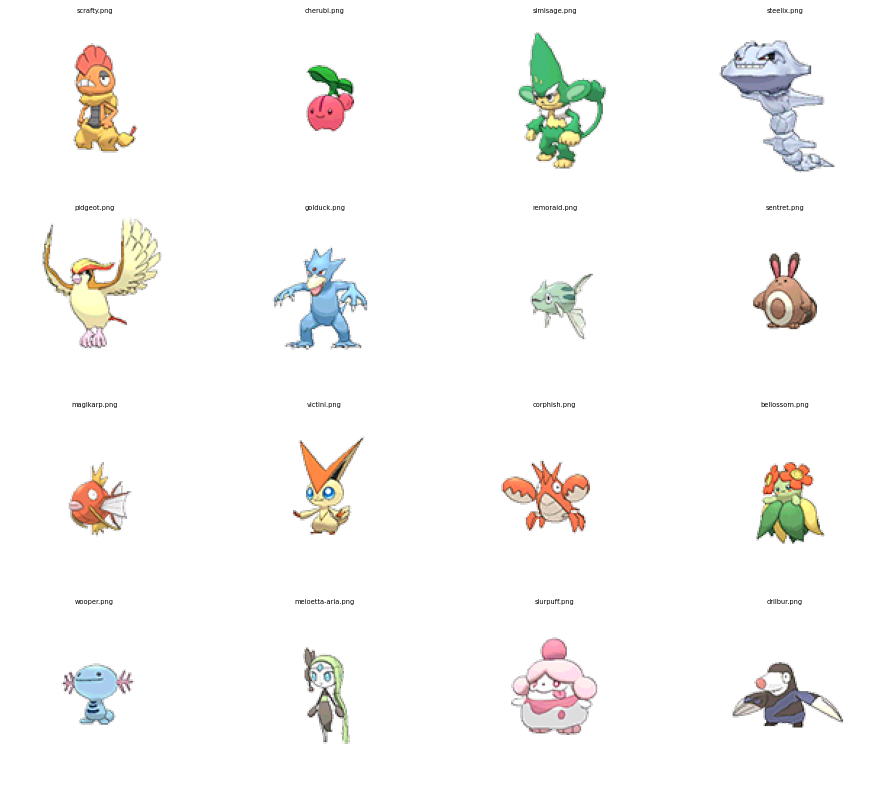

In [26]:
display_sample_images(df, images_dir, num_images=16, rows=4, cols=4)